# Scan MERRA-2 atmospheric properties during one year
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation April 25th 2018

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset tavg1_2d_aer_Nx_M2T1NXAER. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT OBSERVATORY
OBS_NAME='ctio'

In [11]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_aer_Nx_M2T1NXAER"
HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2T1NXRAD_V5.12.4_20180424_203634"

In [12]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [13]:
DATA_TAG=['TAUHGH','TAULOW','TAUMID','TAUTOT']

In [14]:
DATA_TITLE=['In cloud optical thickness of high clouds',
            'In cloud optical thickness of low clouds',
            'In cloud optical thickness of middle clouds',
            'In cloud optical thickness of all clouds'
           ]

In [15]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [16]:
# The selected data field
DATA_NAME =  'tavg1_2d_rad_Nx_M2T1NXRAD'   # 

In [17]:
pandas_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [18]:
fits_filename='MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [19]:
# 6 output files for figures
figfile_rad_tauhigh='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_tauh'+'.jpg'
figfile_rad_taulow='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taul'+'.jpg'
figfile_rad_taumid='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taum'+'.jpg'
figfile_rad_tautot='GMAO_MERRA2_2017_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taut'+'.jpg'

### Select where in the world

In [20]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [21]:
loc

(-70.815, -30.165277777777778, 2214.9999999993697)

### 2.2) Getting the list of the files
------------------------------

In [22]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [23]:
nc4_files[:5]

['MERRA2_400.tavg1_2d_rad_Nx.20170625.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20170508.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20170521.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20170606.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20170616.nc4']

### 2.3) Select files of a given month

In [24]:
keysel_filename='^MERRA2_400.tavg1_2d_rad_Nx.2017.*'

In [25]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.tavg1_2d_rad_Nx.2017.*


In [26]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [27]:
nc4_files2

array(['MERRA2_400.tavg1_2d_rad_Nx.20170625.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170508.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170521.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170606.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170616.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170605.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170614.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170620.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170527.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170615.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170603.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170524.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170529.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170602.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170520.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170624.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170522.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170530.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170619.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20170618.nc4',


### 2.4) Sort files by increasing time

In [28]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [29]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [30]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]


df_tavg1_2d_rad_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print '---------------------------------------------'
    print 'NbDataPerFile = ', NbDataPerFile
    print 'start_time = ', start_time
    print 'time_rng   = ', time_rng[:5]
    
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

            
    #clf_timeseries.append(ts)
    # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3 }, index=time_rng)
    df_tavg1_2d_rad_Nx.append(df)  
    

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2017-04-30 00:30:00']
time_rng   =  DatetimeIndex(['2017-04-30 00:30:00', '2017-04-30 01:30:00',
               '2017-04-30 02:30:00', '2017-04-30 03:30:00',
               '2017-04-30 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2017-05-01 00:30:00']
time_rng   =  DatetimeIndex(['2017-05-01 00:30:00', '2017-05-01 01:30:00',
               '2017-05-01 02:30:00', '2017-05-01 03:30:00',
               '2017-05-01 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2017-05-02 00:30:00']
time_rng   =  DatetimeIndex(['2017-05-02 00:30:00', '2017-05-02 01:30:00',
               '2017-05-02 02:30:00', '2017-05-02 03:30:00',
               '2017-05-02 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

### Concatenation

In [31]:
df_tavg1_2d_rad_Nx=pd.concat(df_tavg1_2d_rad_Nx)

In [32]:
df_tavg1_2d_rad_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2017-04-30 00:30:00 to 2017-06-29 23:30:00
Data columns (total 4 columns):
TAUHGH    1464 non-null float32
TAULOW    1464 non-null float32
TAUMID    1464 non-null float32
TAUTOT    1464 non-null float32
dtypes: float32(4)
memory usage: 34.3 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [33]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_rad_Nx[DATA_TAG[index]].plot(lw=2,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in 2017".format(DATA_TITLE[index],OBS_NAME)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) $\tau$-High-clouds

/pbs/throng/lsst/users/dagoret/External/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


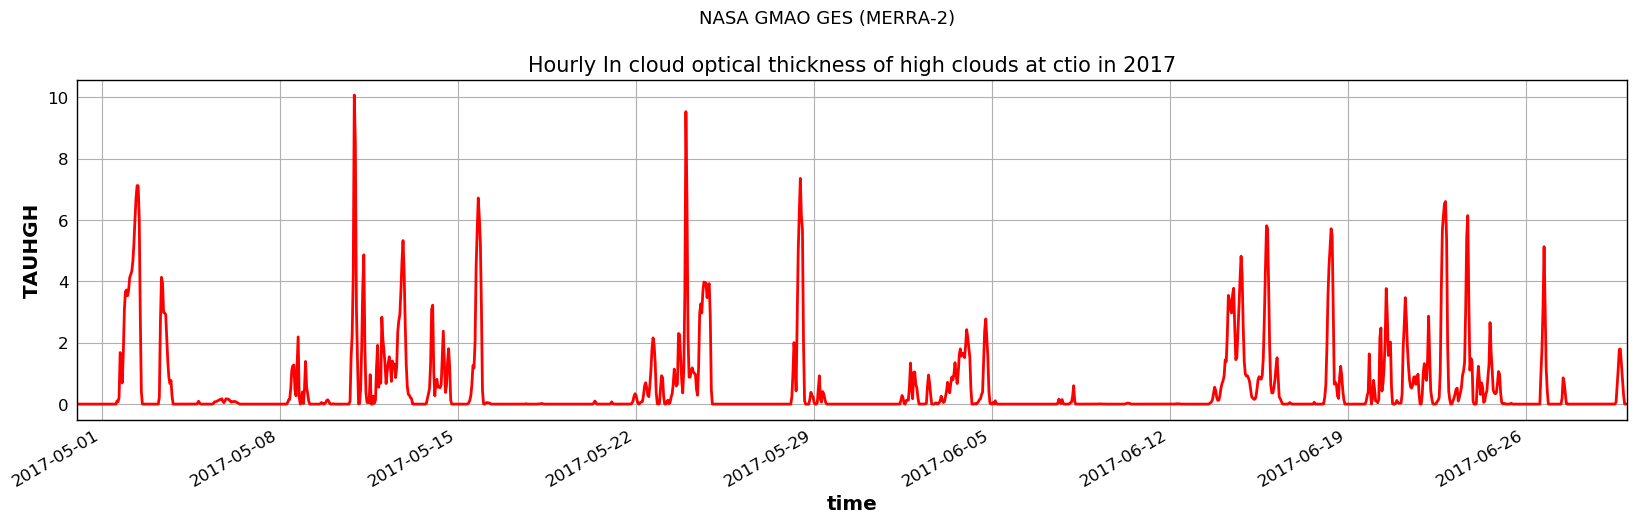

In [34]:
PlotTimeSeries(0,figfile_rad_tauhigh)

###  4.2)  $\tau$-Low-Clouds

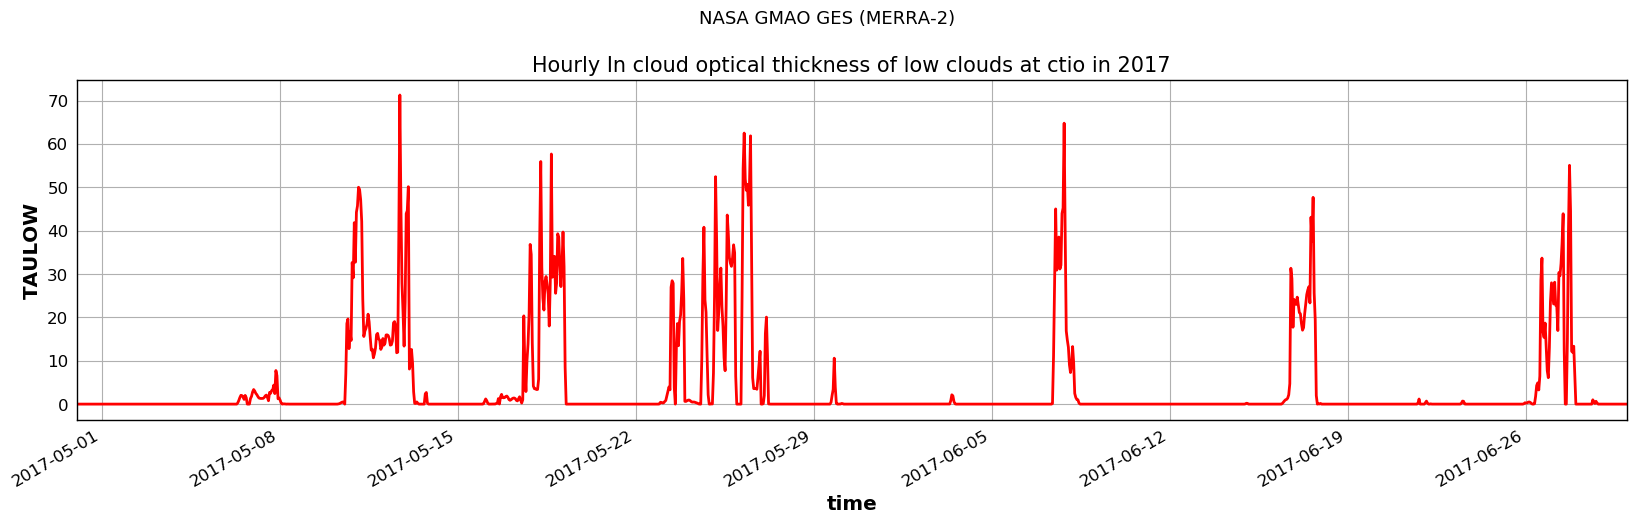

In [35]:
PlotTimeSeries(1,figfile_rad_taulow)

### 4.3) $\tau$-mid-clouds

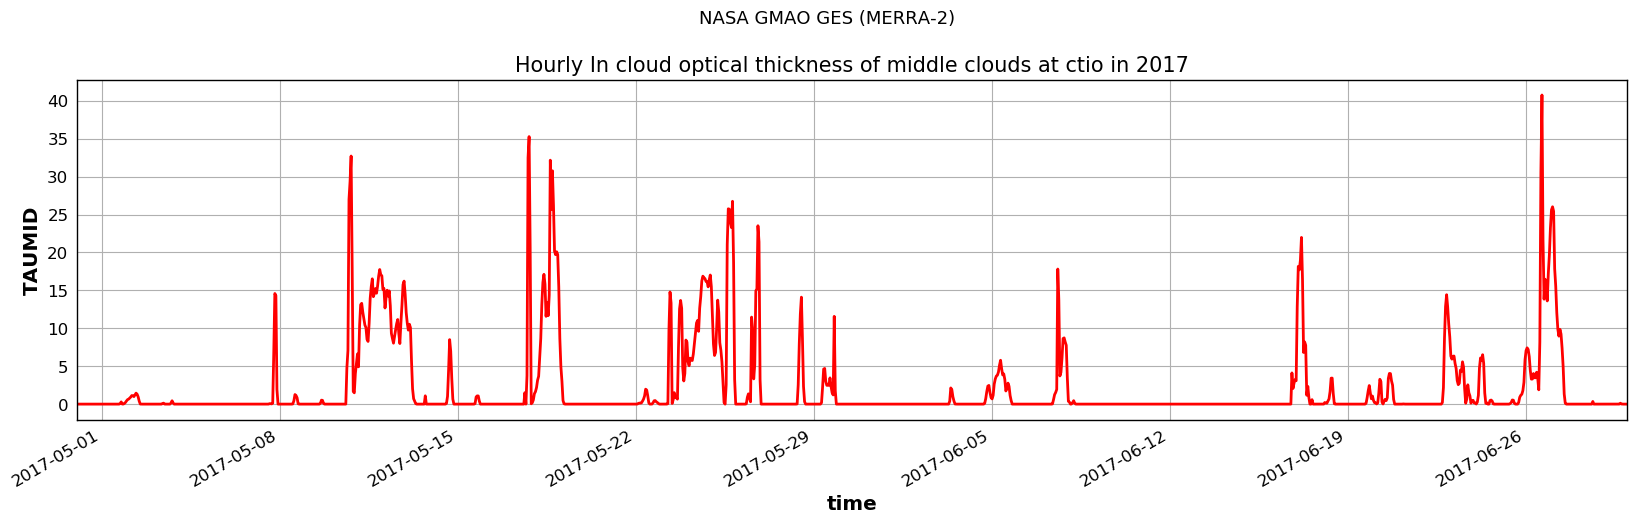

In [36]:
PlotTimeSeries(2,figfile_rad_taumid)

## 4.4) $\tau$- total- clouds

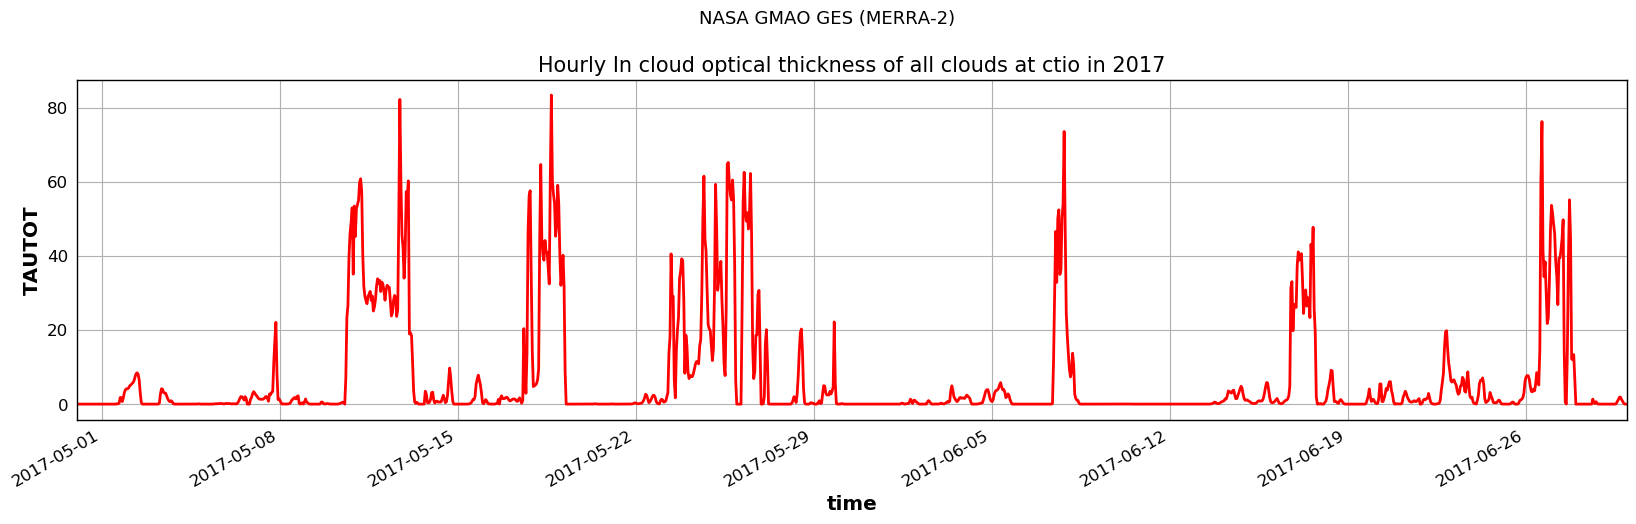

In [37]:
PlotTimeSeries(3,figfile_rad_tautot)

## 5) Output

In [38]:
df_tavg1_2d_rad_Nx.index.name='time'
df_tavg1_2d_rad_Nx.describe()

,TAUHGH,TAULOW,TAUMID,TAUTOT
count,1464.000000,1464.000000,1464.000000,1464.000000
mean,0.542818,4.157959,2.179346,6.880099
std,1.242680,10.600484,5.266803,14.371848
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.391907
75%,0.425903,0.338288,0.656555,3.890381
max,10.078125,71.312500,40.765625,83.375000


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [39]:
dataset=df_tavg1_2d_rad_Nx

In [40]:
dataset.index.name='time'

In [41]:
dataset.describe()

,TAUHGH,TAULOW,TAUMID,TAUTOT
count,1464.000000,1464.000000,1464.000000,1464.000000
mean,0.542818,4.157959,2.179346,6.880099
std,1.242680,10.600484,5.266803,14.371848
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.391907
75%,0.425903,0.338288,0.656555,3.890381
max,10.078125,71.312500,40.765625,83.375000


In [42]:
dataset.head()

,TAUHGH,TAULOW,TAUMID,TAUTOT
time,,,,
2017-04-30 00:30:00,0.0,0.0,0.0,0.0
2017-04-30 01:30:00,0.0,0.0,0.0,0.0
2017-04-30 02:30:00,0.0,0.0,0.0,0.0
2017-04-30 03:30:00,0.0,0.0,0.0,0.0
2017-04-30 04:30:00,0.0,0.0,0.0,0.0


In [43]:
dataset.to_csv(pandas_filename)

In [44]:
saved_dataset=pd.read_csv(pandas_filename)

In [45]:
saved_dataset.head()

,time,TAUHGH,TAULOW,TAUMID,TAUTOT
0,2017-04-30 00:30:00,0.0,0.0,0.0,0.0
1,2017-04-30 01:30:00,0.0,0.0,0.0,0.0
2,2017-04-30 02:30:00,0.0,0.0,0.0,0.0
3,2017-04-30 03:30:00,0.0,0.0,0.0,0.0
4,2017-04-30 04:30:00,0.0,0.0,0.0,0.0


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [46]:
table = Table.from_pandas(saved_dataset)

In [47]:
table

time,TAUHGH,TAULOW,TAUMID,TAUTOT
str19,float64,float64,float64,float64
2017-04-30 00:30:00,0.0,0.0,0.0,0.0
2017-04-30 01:30:00,0.0,0.0,0.0,0.0
2017-04-30 02:30:00,0.0,0.0,0.0,0.0
2017-04-30 03:30:00,0.0,0.0,0.0,0.0
2017-04-30 04:30:00,0.0,0.0,0.0,0.0
2017-04-30 05:30:00,0.0,0.0,0.0,0.0
2017-04-30 06:30:00,0.0,0.0,0.0,0.0
2017-04-30 07:30:00,0.0,0.0,0.0,0.0
2017-04-30 08:30:00,0.0,0.0,0.0,0.0


In [48]:
table.write(fits_filename,format='fits',overwrite=True)